<a href="https://colab.research.google.com/github/brianhphillips/testrepo/blob/main/IMDbScore_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install catboost scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [4]:
import kagglehub
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Download dataset
path = kagglehub.dataset_download("amanbarthwal/imdb-movies-data")
print("Path to dataset files:", path)

100%|██████████| 8.02M/8.02M [00:00<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/amanbarthwal/imdb-movies-data/versions/2


In [5]:
# Step 2: Load dataset
df = pd.read_csv(f"{path}/imdb-movies-dataset.csv")

In [8]:
# Step 3: Basic preprocessing
df = df[['Certificate', 'Duration (min)', 'Genre', 'Director', 'Cast', 'Rating']].copy()
df = df.dropna(subset=['Rating', 'Duration (min)'])  # Remove rows with missing target or numeric inputs

# Fill missing categorical data with a placeholder
for col in ['Certificate', 'Genre', 'Director', 'Cast']:
    df[col] = df[col].fillna('Unknown')

In [9]:
# Step 4: Split dataset
X = df.drop('Rating', axis=1)
y = df['Rating']

# CatBoost can handle categorical features directly
categorical_features = ['Certificate', 'Genre', 'Director', 'Cast']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
# Step 5: Define and train the model
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100,
    early_stopping_rounds=50
)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

model.fit(train_pool, eval_set=test_pool)

0:	learn: 1.0321226	test: 1.0097191	best: 1.0097191 (0)	total: 61.9ms	remaining: 1m 1s
100:	learn: 0.8529612	test: 0.8538683	best: 0.8533804 (98)	total: 795ms	remaining: 7.07s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8533803881
bestIteration = 98

Shrink model to first 99 iterations.


In [11]:
# Step 6: Evaluate model
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\n📊 RMSE: {rmse:.3f}")
print(f"📊 MAE: {mae:.3f}")


📊 RMSE: 0.853
📊 MAE: 0.647


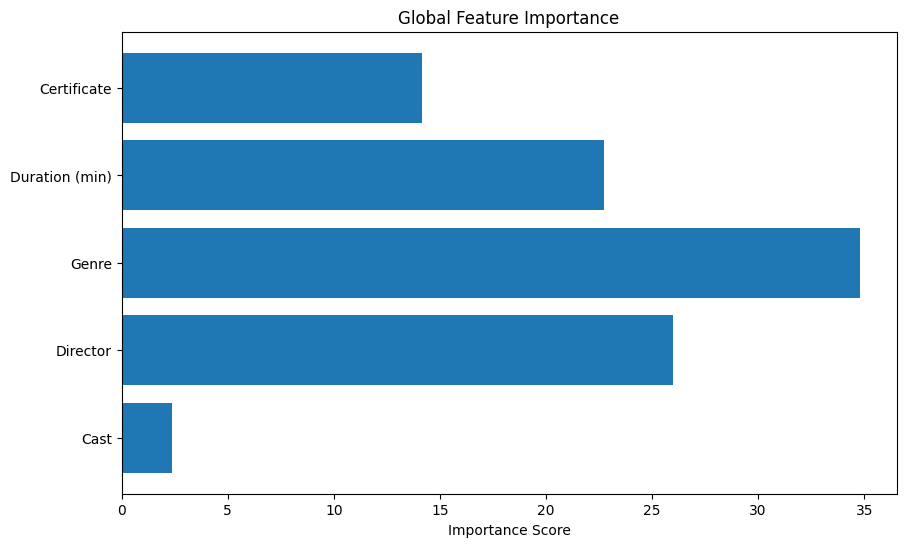

In [12]:
import matplotlib.pyplot as plt

# Get and plot feature importances
feature_importances = model.get_feature_importance(train_pool)
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Importance Score")
plt.title("Global Feature Importance")
plt.gca().invert_yaxis()
plt.show()

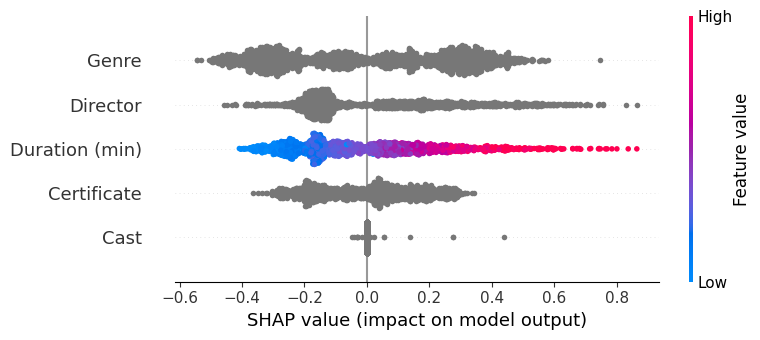

In [13]:
import shap

# Initialize the SHAP explainer from CatBoost
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot (feature direction + magnitude)
shap.summary_plot(shap_values, X_test, plot_type="dot")

In [15]:
# Group by Certificate and calculate average IMDb rating
avg_ratings_by_cert = df.groupby('Certificate')['Rating'].mean().sort_values(ascending=False)

# Display results
print(avg_ratings_by_cert)

Certificate
M/PG         7.600000
GP           7.400000
Approved     7.100000
Unrated      7.100000
U/A          7.066667
G            6.943750
12+          6.886667
U            6.744743
Not Rated    6.725455
7            6.642857
UA           6.638055
A            6.584193
16           6.532710
UA 16+       6.455000
13           6.440541
(Banned)     6.425000
15+          6.400000
All          6.392308
18           6.380303
UA 13+       6.353488
PG           6.329918
16+          6.300000
Unknown      6.288440
PG-13        6.223171
R            6.211522
12           6.000000
NC-17        5.950000
UA 7+        5.931579
U/A 16+      5.800000
X            5.700000
18+          4.550000
Name: Rating, dtype: float64


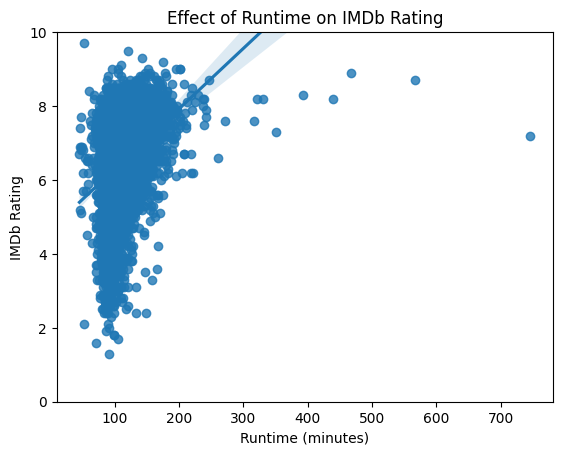

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x='Duration (min)', y='Rating', data=df)
plt.ylim(0, 10)  # Force y-axis to stay between 0 and 10
plt.title("Effect of Runtime on IMDb Rating")
plt.xlabel("Runtime (minutes)")
plt.ylabel("IMDb Rating")
plt.show()

In [19]:
# Group by director and calculate average rating and number of movies
director_avg_ratings = df.groupby('Director').agg(
    Average_Rating=('Rating', 'mean'),
    Movie_Count=('Rating', 'count')
)

# Optional: filter out directors with very few movies to ensure reliability
director_avg_ratings = director_avg_ratings[director_avg_ratings['Movie_Count'] >= 2]

# Sort by average rating and get the top 20
top_20_directors = director_avg_ratings.sort_values(by='Average_Rating', ascending=False).head(20)

print(top_20_directors)

                       Average_Rating  Movie_Count
Director                                          
Charles Chaplin              8.400000            4
Lee Unkrich                  8.350000            2
Christian Sparkes            8.250000            2
Sergio Leone                 8.216667            6
Frank Capra                  8.175000            4
Christopher Nolan            8.166667           12
Akira Kurosawa               8.160000           10
Asif Kapadia                 8.150000            2
Moustapha Akkad              8.150000            2
Henri-Georges Clouzot        8.150000            2
Edward Yang                  8.150000            2
Pete Docter                  8.125000            4
Béla Tarr                    8.100000            2
Tony Kaye                    8.100000            2
Stanley Kubrick              8.090909           11
Quentin Tarantino            8.081818           11
Ingmar Bergman               8.066667            6
Ernst Lubitsch               8.